In [56]:
import tensorflow as tf
from tensorflow import keras
import os 


In [57]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [58]:
tf.test.is_built_with_cuda()
print(tf.version.VERSION)
import sys
sys.version

2.10.0


'3.9.13 (main, Oct 13 2022, 21:23:06) [MSC v.1916 64 bit (AMD64)]'

In [59]:
os.chdir('C:/Users/LSUSStudent/Desktop/ALL_FILES/CSC667-Project/Dataset_BUSI_with_GT')

In [60]:
pwd

'C:\\Users\\LSUSStudent\\Desktop\\ALL_FILES\\CSC667-Project\\Dataset_BUSI_with_GT'

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os


import pydot
import graphviz 



from tensorflow.keras import layers, activations, optimizers, losses, metrics, initializers
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV3Small, MobileNet, InceptionV3
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input, decode_predictions

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn import tree
from sklearn.metrics import accuracy_score

from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras import applications



seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [62]:
dir_path = r'C:/Users/LSUSStudent/Desktop/ALL_FILES/CSC667-Project/Dataset_BUSI_with_GT/'
IMAGE_SHAPE = (224, 224)

In [63]:
# create prepare_image method
# used to preprocess the image for efficientNet model
def prepare_image(file):
    img = image.load_img(file, target_size=IMAGE_SHAPE)
    img_array = image.img_to_array(img)
    return tf.keras.applications.efficientnet.preprocess_input (img_array)

In [64]:
directories = os.listdir(dir_path) # read the folders

files = [] # save all images for each folder
labels = [] # set for each image the name of it

# read files for each directory
for folder in directories:
    
    fileList = glob.glob(dir_path + '/'+ folder + '/*')
    labels.extend([folder for l in fileList])
    files.extend(fileList)
    
len(files), len(labels)

(1312, 1312)

In [65]:
# create two lists to hold only non-mask images and label for each one
selected_files = []
selected_labels = []

for file, label in zip(files, labels):
    if 'mask' not in file:
        selected_files.append(file)
        selected_labels.append(label)

    
len(selected_files), len(selected_labels)

(647, 647)

In [66]:
# the dictionary holds list of images and for each one has its target/label
images = {
    'image': [], 
    'target': []
}

print('Preparing the image...')

for i, (file, label) in enumerate(zip(selected_files, selected_labels)):
    images['image'].append(prepare_image(file))
    images['target'].append(label)

print('Finished.')

Preparing the image...
Finished.


In [67]:
# convert lists to arrays 
images['image'] = np.array(images['image'])
images['target'] = np.array(images['target'])

# encode the target
le = LabelEncoder()

images['target'] = le.fit_transform(images['target'])

classes = le.classes_ # get the classes for each target
print(f'the target classes are: {classes}')

the target classes are: ['benign' 'malignant']


In [68]:

x_train, x_test, y_train, y_test = train_test_split(images['image'], images['target'], test_size=.10)

x_train.shape, x_test.shape, y_train.shape, y_test.shape 

((582, 224, 224, 3), (65, 224, 224, 3), (582,), (65,))

In [69]:
x_train = x_train.reshape(582,224*224*3)
x_test = x_test.reshape(65,224*224*3)


In [70]:
# creating the Decision Tree classifier


clf = tree.DecisionTreeClassifier()
clf.fit(x_train,y_train)

pred = clf.predict(x_test)

print("Accuracy for Decision Tree =", accuracy_score(pred, y_test)*100, "%")

Accuracy for Decision Tree = 69.23076923076923 %


In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rfc = RandomForestClassifier(random_state=0)
# fit the model

rfc.fit(x_train, y_train)

# Predict the Test set results
y_pred = rfc.predict(x_test)
# Check accuracy score 

print("Accuracy with Random forest =", accuracy_score(y_pred, y_test)*100, "%")

Accuracy with Random forest = 83.07692307692308 %


In [72]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix


svc_model = SVC() #initialize the code module
svc_model.fit(x_train,y_train)


y_predict = svc_model.predict(x_test) # get 'y' by predict FOR the TEST values.
cm = confusion_matrix(y_test,y_predict)
display(cm)

print("Accuracy for SVC =", accuracy_score(y_predict, y_test)*100, "%")

array([[46,  2],
       [ 8,  9]], dtype=int64)

Accuracy for SVC = 84.61538461538461 %


TRANSFER LEARNING

In [18]:
from keras.applications.vgg19 import VGG19
base_model = VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMAGE_SHAPE, 3),
    classes=2)

# Freeze the base_model
base_model.trainable = False

In [19]:
add_model1 = Sequential()
add_model1.add(base_model)
add_model1.add(GlobalAveragePooling2D())
add_model1.add(Dense(128, activation = 'sigmoid'))
add_model1.add(Dropout(0.5))
add_model1.add(Dense(1, activation='sigmoid'))

vgg_model = add_model1

In [20]:
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 20,090,177
Trainable params: 65,793
Non-trainable params: 20,024,384
_______________________________________

In [21]:
x_train, x_test, y_train, y_test = train_test_split(images['image'], images['target'], test_size=.10)

x_train.shape, x_test.shape, y_train.shape, y_test.shape 

((582, 224, 224, 3), (65, 224, 224, 3), (582,), (65,))

In [22]:
batch_size=50
epochs=100

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

custom_early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=40,
    restore_best_weights=True
)

In [24]:
vgg_model.compile(optimizer=tf.keras.optimizers.Adam() , loss = "binary_crossentropy", metrics=["accuracy"]) #tf.keras.optimizers.Adam(0.01)


In [25]:
history1 =  vgg_model.fit(x_train,y_train, batch_size=batch_size,epochs=epochs,
                              verbose=1,
                              validation_data =(x_test,y_test),callbacks=[custom_early_stopping])

Epoch 1/100
12/12 [==============================] - 16s 803ms/step - loss: 0.6676 - accuracy: 0.6460 - val_loss: 0.5937 - val_accuracy: 0.6615
Epoch 2/100
12/12 [==============================] - 2s 198ms/step - loss: 0.5623 - accuracy: 0.7062 - val_loss: 0.5602 - val_accuracy: 0.6769
Epoch 3/100
12/12 [==============================] - 2s 199ms/step - loss: 0.4902 - accuracy: 0.7801 - val_loss: 0.5084 - val_accuracy: 0.7231
Epoch 4/100
12/12 [==============================] - 2s 199ms/step - loss: 0.4418 - accuracy: 0.8024 - val_loss: 0.4687 - val_accuracy: 0.7385
Epoch 5/100
12/12 [==============================] - 2s 195ms/step - loss: 0.4203 - accuracy: 0.8144 - val_loss: 0.4795 - val_accuracy: 0.7385
Epoch 6/100
12/12 [==============================] - 2s 199ms/step - loss: 0.4046 - accuracy: 0.8162 - val_loss: 0.4393 - val_accuracy: 0.7692
Epoch 7/100
12/12 [==============================] - 2s 199ms/step - loss: 0.3817 - accuracy: 0.8368 - val_loss: 0.4183 - val_accuracy: 0.830

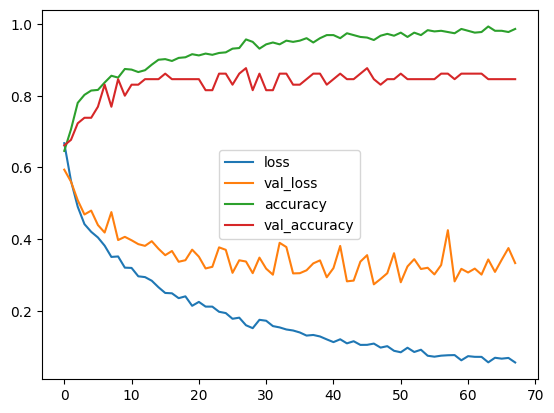

In [26]:
hist = history1.history

plt.plot(hist['loss'], label=  'loss')
plt.plot(hist['val_loss'], label = 'val_loss')
plt.plot(hist['accuracy'], label='accuracy')
plt.plot(hist['val_accuracy'], label='val_accuracy')
plt.legend()

In [27]:
score = vgg_model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])



2/2 [==============================] - 0s 51ms/step - loss: 0.3375 - accuracy: 0.8769
Test loss: 0.3374849557876587
Test accuracy: 0.8769230842590332


In [28]:
score = vgg_model.evaluate(x_train, y_train, batch_size=batch_size, verbose=1)

print('Train loss:', score[0])
print('Train accuracy:', score[1])

12/12 [==============================] - 2s 174ms/step - loss: 0.1450 - accuracy: 0.9553
Train loss: 0.14501525461673737
Train accuracy: 0.9553264379501343


In [29]:
# used to predict the model and visualize the orignal image with title of true and pred values
def predict_image(img_path, label):
    img1 = prepare_image(img_path) # preprocess the image
    res = vgg_model.predict(np.expand_dims(img1, axis = 0)) # predict the image
    pred = classes[np.argmax(res)]

    # Visualize the image
    img = image.load_img(img_path)
    plt.imshow(np.array(img))
    plt.title(f'True: {label}\nPredicted: {pred}')

1/1 [==============================] - 1s 634ms/step


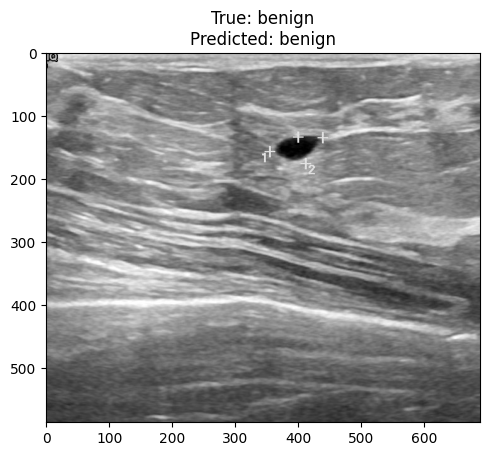

In [30]:
predict_image(dir_path + 'benign/benign (11).png', 'benign')


1/1 [==============================] - 0s 18ms/step


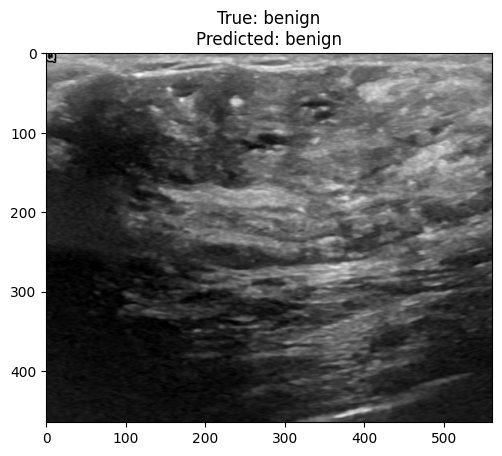

In [31]:
predict_image(dir_path + 'benign/benign (85).png', 'benign')


1/1 [==============================] - 0s 19ms/step


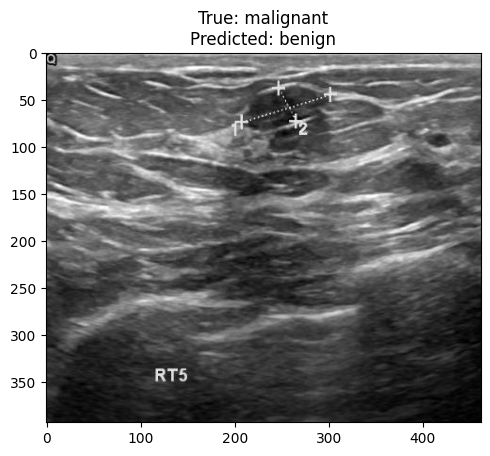

In [32]:
predict_image(dir_path + 'malignant/malignant (10).png', 'malignant')


In [33]:
predicted = []
for item in vgg_model.predict(x_test):
    predicted.append(np.argmax(item))

3/3 [==============================] - 0s 93ms/step


In [34]:
x_test.shape


(65, 224, 224, 3)

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf = confusion_matrix(y_test,predicted)
conf

array([[40,  0],
       [25,  0]], dtype=int64)

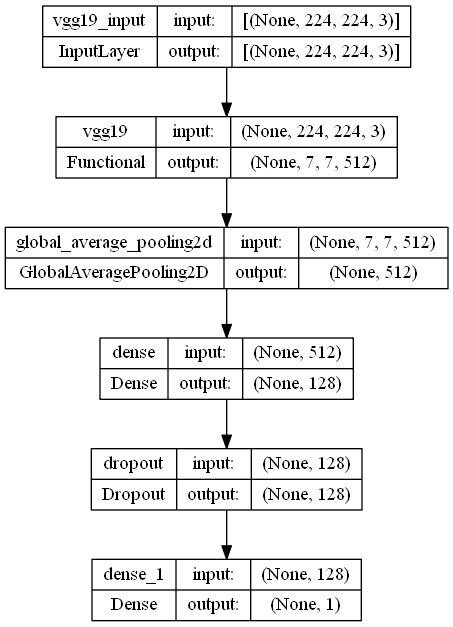

In [36]:
from keras.utils.vis_utils import plot_model
plot_model(vgg_model, to_file='aug_model_plot.png', show_shapes=True, show_layer_names=True)

In [37]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras import applications

In [38]:

base_model2 = applications.InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(224, 224,3))
base_model2.trainable = False

In [39]:

add_model2 = Sequential()
add_model2.add(base_model2)
add_model2.add(Dense(128, activation = 'sigmoid'))
add_model2.add(Dropout(0.5))
add_model2.add(Flatten())
add_model2.add(Dense(1, activation='sigmoid'))

inception_model = add_model2

inception_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 dense_2 (Dense)             (None, 5, 5, 128)         262272    
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 128)         0         
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3201      
                                                                 
Total params: 22,068,257
Trainable params: 265,473
Non-trainable params: 21,802,784
_________________________________________________________________


In [40]:
from tensorflow.keras.callbacks import EarlyStopping

custom_early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=40,
    restore_best_weights=True
)

In [41]:
inception_model.compile(optimizer=tf.keras.optimizers.Adam() , 
                        loss = "binary_crossentropy", 
                        metrics=["accuracy"]) #tf.keras.optimizers.Adam(0.01)


In [42]:
history2 =  inception_model.fit(x_train,y_train, batch_size=batch_size,epochs=epochs,
                              verbose=1,
                              validation_data =(x_test,y_test),callbacks=[custom_early_stopping])

Epoch 1/100
12/12 [==============================] - 10s 366ms/step - loss: 0.7749 - accuracy: 0.6237 - val_loss: 0.6456 - val_accuracy: 0.6154
Epoch 2/100
12/12 [==============================] - 1s 97ms/step - loss: 0.6182 - accuracy: 0.7045 - val_loss: 0.5806 - val_accuracy: 0.6769
Epoch 3/100
12/12 [==============================] - 1s 88ms/step - loss: 0.5681 - accuracy: 0.7165 - val_loss: 0.5857 - val_accuracy: 0.6615
Epoch 4/100
12/12 [==============================] - 1s 98ms/step - loss: 0.5554 - accuracy: 0.7440 - val_loss: 0.5559 - val_accuracy: 0.7692
Epoch 5/100
12/12 [==============================] - 1s 86ms/step - loss: 0.5496 - accuracy: 0.7354 - val_loss: 0.5215 - val_accuracy: 0.7385
Epoch 6/100
12/12 [==============================] - 1s 87ms/step - loss: 0.5602 - accuracy: 0.7302 - val_loss: 0.5322 - val_accuracy: 0.7385
Epoch 7/100
12/12 [==============================] - 1s 97ms/step - loss: 0.5375 - accuracy: 0.7423 - val_loss: 0.5200 - val_accuracy: 0.7846
Epoc

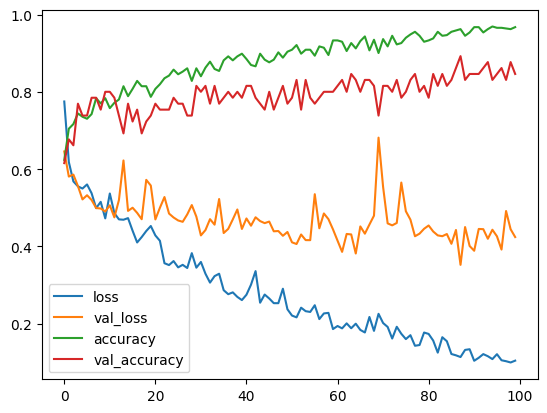

In [43]:
hist = history2.history

plt.plot(hist['loss'], label=  'loss')
plt.plot(hist['val_loss'], label = 'val_loss')
plt.plot(hist['accuracy'], label='accuracy')
plt.plot(hist['val_accuracy'], label='val_accuracy')
plt.legend()

In [44]:
score = inception_model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

2/2 [==============================] - 0s 38ms/step - loss: 0.4240 - accuracy: 0.8462
Test loss: 0.4240226745605469
Test accuracy: 0.8461538553237915


In [45]:
score = inception_model.evaluate(x_train, y_train, batch_size=batch_size, verbose=1)

print('Train loss:', score[0])
print('Train accuracy:', score[1])

12/12 [==============================] - 1s 73ms/step - loss: 0.0685 - accuracy: 0.9863
Train loss: 0.06851064413785934
Train accuracy: 0.9862542748451233


In [46]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from keras.optimizers import Adam, RMSprop

input_shape = (224,224,3)
lr = 1e-5
epochs = 50
batch_size = 64


In [47]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

In [48]:
base_model3 = ResNet50V2(include_top=False,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)
base_model2.trainable = False


In [49]:
add_model3 = Sequential()
add_model3.add(base_model3)
add_model3.add(Dense(128, activation = 'sigmoid'))
add_model3.add(Dropout(0.5))
add_model3.add(Flatten())
add_model3.add(Dense(1, activation='sigmoid'))

ResNet_model = add_model3

ResNet_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23,827,201
Trainable params: 23,781,761
Non-trainable params: 45,440
_________________________________________________________________


In [50]:
ResNet_model.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

In [51]:
history3 =  ResNet_model.fit(x_train,y_train, batch_size=batch_size,epochs=epochs,
                              verbose=1,
                              validation_data =(x_test,y_test),callbacks=[custom_early_stopping])

Epoch 1/50
10/10 [==============================] - 15s 650ms/step - loss: 0.8647 - accuracy: 0.4296 - val_loss: 0.6983 - val_accuracy: 0.4923
Epoch 2/50
10/10 [==============================] - 4s 365ms/step - loss: 0.7568 - accuracy: 0.5155 - val_loss: 0.6812 - val_accuracy: 0.5846
Epoch 3/50
10/10 [==============================] - 4s 351ms/step - loss: 0.7067 - accuracy: 0.5704 - val_loss: 0.6905 - val_accuracy: 0.5385
Epoch 4/50
10/10 [==============================] - 4s 352ms/step - loss: 0.6656 - accuracy: 0.6151 - val_loss: 0.7129 - val_accuracy: 0.4615
Epoch 5/50
10/10 [==============================] - 4s 352ms/step - loss: 0.6437 - accuracy: 0.6478 - val_loss: 0.7349 - val_accuracy: 0.4308
Epoch 6/50
10/10 [==============================] - 4s 353ms/step - loss: 0.6287 - accuracy: 0.6460 - val_loss: 0.7588 - val_accuracy: 0.4000
Epoch 7/50
10/10 [==============================] - 4s 351ms/step - loss: 0.5743 - accuracy: 0.7079 - val_loss: 0.7824 - val_accuracy: 0.3846
Epoch

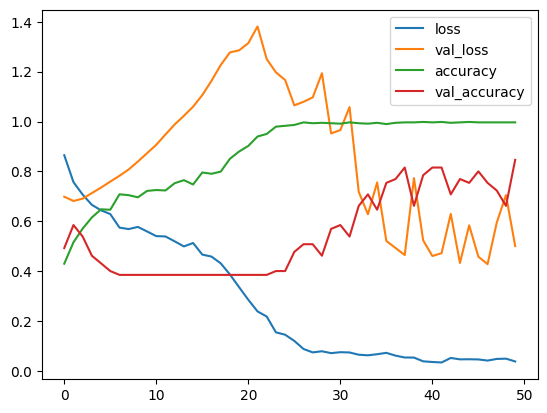

In [52]:
hist = history3.history

plt.plot(hist['loss'], label=  'loss')
plt.plot(hist['val_loss'], label = 'val_loss')
plt.plot(hist['accuracy'], label='accuracy')
plt.plot(hist['val_accuracy'], label='val_accuracy')
plt.legend()

In [53]:
score = ResNet_model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

2/2 [==============================] - 0s 17ms/step - loss: 0.5004 - accuracy: 0.8462
Test loss: 0.5004146695137024
Test accuracy: 0.8461538553237915


In [54]:
score = ResNet_model.evaluate(x_train, y_train, batch_size=batch_size, verbose=1)

print('Train loss:', score[0])
print('Train accuracy:', score[1])

10/10 [==============================] - 1s 108ms/step - loss: 0.1008 - accuracy: 0.9622
Train loss: 0.10082986205816269
Train accuracy: 0.962199330329895
